# Collaborators:
* Mariam Sherif Almotawally
* Rita Emad Roshdy
* Feras Nezar Elkkharrat

# Imports

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from absl import logging
logging.set_verbosity(logging.ERROR)

2024-05-14 02:13:06.904174: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 02:13:07.562889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 02:13:08.584867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading the Data

In [2]:
data_dir = "./clips"
videos = os.listdir(data_dir)
labels = []

for i in range(len(videos)):
    labels.append(videos[i].split("_")[1])

df = pd.DataFrame(data = {'path': videos, 'label': labels})

df = df.sample(frac=1).reset_index(drop = True)

df.head()

,path,label
0,v_Basketball_g17_c03.avi,Basketball
1,v_Diving_g07_c04.avi,Diving
2,v_Basketball_g03_c03.avi,Basketball
3,v_Diving_g21_c03.avi,Diving
4,v_Diving_g23_c06.avi,Diving


# Preprocessing Inputs and Preparation for Training

## Making some helper functions to prepare our videos

In [3]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=50, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0


## Converting the labels to integers using LabelEncoder


In [4]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [5]:
df.head()

,path,label
0,v_Basketball_g17_c03.avi,0
1,v_Diving_g07_c04.avi,1
2,v_Basketball_g03_c03.avi,0
3,v_Diving_g21_c03.avi,1
4,v_Diving_g23_c06.avi,1


In [6]:
df.shape

(407, 2)

# Designing the CNN Architecture

## We are using the InceptionV3 pre-trained model to extract features from individual video frames

In [7]:
def create_feature_extractor():
  feature_extractor = InceptionV3(
      weights='imagenet',
      include_top=False,
      pooling='avg',
      input_shape=(224, 224, 3))
  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  inputs = tf.keras.Input((224, 224, 3))
  preprocessed = preprocess_input(inputs)
  outputs = feature_extractor(preprocessed)
  return tf.keras.Model(inputs, outputs, name='feature_extractor')

feature_extractor = create_feature_extractor()

2024-05-14 02:13:10.830621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 02:13:11.197558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 02:13:11.197692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Helper function to extract the features from the frames of a video

In [8]:
def extract_video_features(frames):
  return feature_extractor.predict(frames)

## Splitting our data into labels and features initially

In [9]:
X = []
y = []

for i in range(len(df)):
    path = os.path.join(data_dir, df.path[i])
    frames = load_video(path)
    features = extract_video_features(frames)
    X.append(features)
    y.append(df.label[i])

X = np.array(X)
y = np.array(y)

I0000 00:00:1715641993.866308   68748 service.cc:145] XLA service 0x78056c002820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715641993.866346   68748 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-14 02:13:13.971641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 02:13:14.554630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


1/2 ━━━━━━━━━━━━━━━━━━━━ 13s 14s/step

I0000 00:00:1715642006.722548   68748 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 12s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━

## Splitting our data into training, testing and validation datasets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Implementing the RNN LSTM Architecture and Feeding CNN Features in

In [11]:
video_model = tf.keras.Sequential([
    layers.Input(shape=(50, 2048)),
    layers.LSTM(512),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
])

video_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

video_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 512)            │     5,244,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,509,123 (21.02 MB)

 Trainable params: 5,509,123 (21.02 MB)

 Non-trainable params: 0 (0.00 B)

# C-RNN Implementation

## Defining a callback function to stop training early if it sees it fit

In [12]:
early_stopping_callback = EarlyStopping(monitor='accuracy', patience=10, mode='max', restore_best_weights=True)

## Training the model

In [13]:
video_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping_callback])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.3784 - loss: 1.3185 - val_accuracy: 0.3804 - val_loss: 1.4548
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4015 - loss: 1.2746 - val_accuracy: 0.3006 - val_loss: 1.2607
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4144 - loss: 1.1849 - val_accuracy: 0.5215 - val_loss: 1.0405
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5357 - loss: 0.9746 - val_accuracy: 0.4663 - val_loss: 1.0821
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5431 - loss: 0.9188 - val_accuracy: 0.6074 - val_loss: 0.8628
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5346 - loss: 0.8959 - val_accuracy: 0.4233 - val_loss: 1.0389
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3826 - loss: 1.1474 - val_accuracy: 0.4479 - val_loss: 1.1661
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5815 - loss: 0.9204 - val_accuracy: 0.6258 - val_loss

# Evaluation

## Producing a report of all evaluation metrics

In [14]:
y_pred = video_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
              precision    recall  f1-score   support

  Basketball       0.77      0.96      0.86        25
      Diving       0.93      0.87      0.90        31
 JumpingJack       1.00      0.85      0.92        26

    accuracy                           0.89        82
   macro avg       0.90      0.89      0.89        82
weighted avg       0.91      0.89      0.89        82



## Plotting a confusion matrix using a heatmap

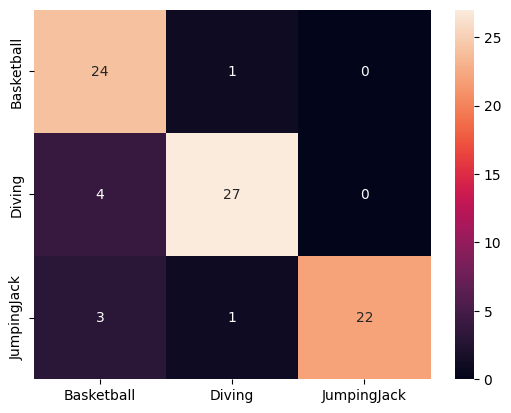

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.show()